In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import matplotlib.pyplot as plt
import pylab
import librosa
import librosa.display
import numpy as np
import pandas as pd
import io
import tarfile
import PIL
import boto3
from fastai import *
from fastai.vision import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
sz = 128
bs = 128
nfolds = 4 #keep the same split as the initial dataset
fold = 0
SEED = 2019
TRAIN = '../input/grapheme-imgs-128x128/'
LABELS = '../input/bengaliai-cv19/train.csv'

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [ ]:
len(os.listdir(TRAIN))

In [ ]:
df = pd.read_csv(LABELS)
nunique = list(df.nunique())[1:-1]
print(nunique)
df.tail()

In [ ]:
stats = ([0.0692], [0.2051])
data = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['grapheme_root'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

data.show_batch()

In [ ]:
learn = cnn_learner(data, models.densenet121)

In [ ]:
learn.lr_find()
learn.recorder.plot()

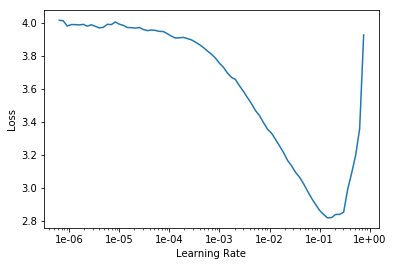
FOR [grapheme_root]: lr=1e-02

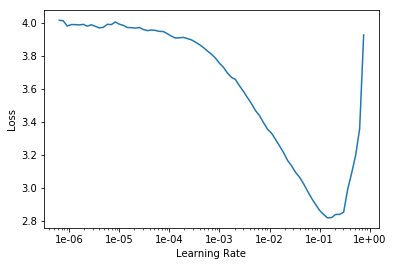
FOR 'vowel_diacritic': lr=1e-02

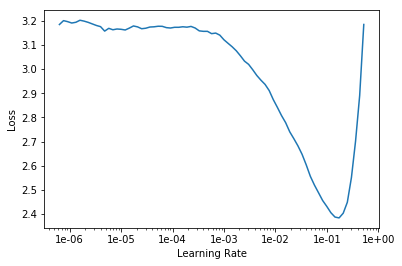
FOR ['consonant_diacritic']: lr=1e-02

In [ ]:
#lr=1e-02

In [ ]:
#learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('dense-1')


In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

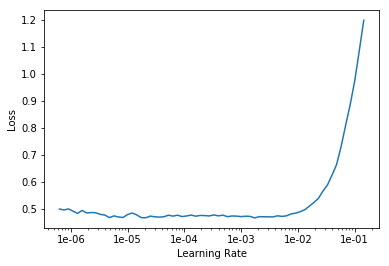

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-03,1e-5))

In [ ]:
learn.show_results()

In [ ]:
learn.save('denseuf-1')

In [ ]:
stats = ([0.0692], [0.2051])
data2 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['vowel_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data2.show_batch()

In [ ]:
learn = cnn_learner(data2, models.densenet121)

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('dense-2')

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

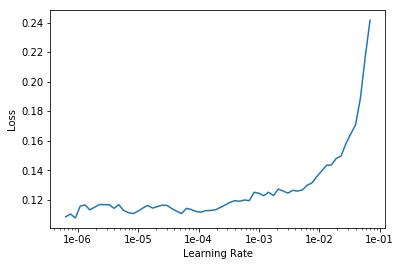

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-04,1e-6))

In [ ]:
learn.show_results()

In [ ]:
learn.save('denseuf-2')

In [ ]:
stats = ([0.0692], [0.2051])
data3 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data2.show_batch()

In [ ]:
learn = cnn_learner(data3, models.densenet121)

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('dense-3')

In [ ]:
learn.show_results()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

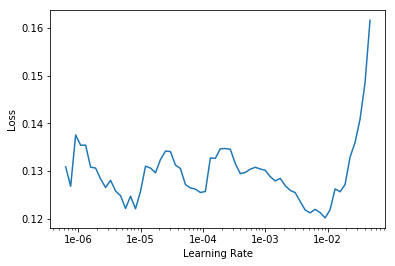

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2,max_lr=slice(1e-02,1e-3))

In [ ]:
learn.show_results()

In [ ]:
learn.save('denseuf-3')

In [ ]:
'''import cv2
from tqdm import tqdm_notebook as tqdm
import zipfile
import io
import warnings
warnings.filterwarnings("ignore")'''

In [ ]:
HEIGHT = 137
WIDTH = 236
SIZE = 128

#TEST = ['/kaggle/input/bengaliai-cv19/test_image_data_0.parquet',
#         '/kaggle/input/bengaliai-cv19/test_image_data_1.parquet',
#         '/kaggle/input/bengaliai-cv19/test_image_data_2.parquet',
#         '/kaggle/input/bengaliai-cv19/test_image_data_3.parquet']

#OUT_TEST = 'test.zip'

In [ ]:
#def bbox(img):
#    rows = np.any(img, axis=1)
#   cols = np.any(img, axis=0)
#    rmin, rmax = np.where(rows)[0][[0, -1]]
#    cmin, cmax = np.where(cols)[0][[0, -1]]
#    return rmin, rmax, cmin, cmax

#def crop_resize(img0, size=SIZE, pad=16):
#    #crop a box around pixels large than the threshold 
#    #some images contain line at the sides
#    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
#    #cropping may cut too much, so we need to add it back
#    xmin = xmin - 13 if (xmin > 13) else 0
#    ymin = ymin - 10 if (ymin > 10) else 0
#    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
#    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
#    img = img0[ymin:ymax,xmin:xmax]
#    #remove lo intensity pixels as noise
#    img[img < 28] = 0
#    lx, ly = xmax-xmin,ymax-ymin
#    l = max(lx,ly) + pad
#    #make sure that the aspect ratio is kept in rescaling
#    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
 #   return cv2.resize(img,(size,size))

In [ ]:
#df = pd.read_parquet(TEST[0])
#n_imgs = 3
#fig, axs = plt.subplots(n_imgs, 2, figsize=(10, 5*n_imgs))

#for idx in range(n_imgs):
#    #somehow the original input is inverted
#    img0 = 255 - df.iloc[idx, 1:].values.reshape(HEIGHT, WIDTH).astype(np.uint8)
#    #normalize each image by its max val
#    img = (img0*(255.0/img0.max())).astype(np.uint8)
 #   img = crop_resize(img)

#    axs[idx,0].imshow(img0)
#    axs[idx,0].set_title('Original image')
#    axs[idx,0].axis('off')
#    axs[idx,1].imshow(img)
#    axs[idx,1].set_title('Crop & resize')
#    axs[idx,1].axis('off')
#plt.show()

In [ ]:
#x_tot,x2_tot = [],[]
#with zipfile.ZipFile(OUT_TEST, 'w') as img_out:
#    for fname in TEST:
#        df = pd.read_parquet(fname)
#        #the input is inverted
#        data = 255 - df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH).astype(np.uint8)
#        for idx in tqdm(range(len(df))):
#            name = df.iloc[idx,0]
#            #normalize each image by its max val
#            img = (data[idx]*(255.0/data[idx].max())).astype(np.uint8)
#            img = crop_resize(img)
#        
#            x_tot.append((img/255.0).mean())
#            x2_tot.append(((img/255.0)**2).mean()) 
#            img = cv2.imencode('.png',img)[1]
#            img_out.writestr(name + '.png', img)


In [ ]:
'''stats = ([0.0692], [0.2051])
data1 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['grapheme_root'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)'''


#data1.show_batch()

In [ ]:
'''stats = ([0.0692], [0.2051])
data2 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['vowel_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data2.show_batch()'''

In [ ]:
'''stats = ([0.0692], [0.2051])
data3 = (ImageList.from_df(df, path='.', folder=TRAIN, suffix='.png', 
        cols='image_id')
        .split_by_idx(range(fold*len(df)//nfolds,(fold+1)*len(df)//nfolds))
        .label_from_df(cols=['consonant_diacritic'])
        .transform(get_transforms(do_flip=False,max_warp=0.1), size=sz, padding_mode='zeros')
        .databunch(bs=bs)).normalize(stats)

#data3.show_batch()'''

In [ ]:
'''doc(cnn_learner)'''

In [ ]:
'''learn1 = cnn_learner(data1, models.resnet34)
learn2 = cnn_learner(data2, models.resnet34)
learn3 = cnn_learner(data3, models.resnet34)'''

In [ ]:
'''learn1.load('/kaggle/input/saved-models/stage-1')
learn2.load('/kaggle/input/saved-models/stage-2')
learn3.load('/kaggle/input/saved-models/stage-3')'''

In [ ]:
'''OUTPUT=[]
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
for i in  range(0,12):
    img = open_image(get_image_files('/kaggle/input/test-bengali')[i])
    img.show()
    A=learn1.predict(img)[0]
    B=learn2.predict(img)[0]
    C=learn3.predict(img)[0]
    print([A,B,C])'''

In [ ]:
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

In [ ]:
'''sub=pd.read_csv('../input/submission/sample_submission.csv')'''

In [ ]:
'''sub.to_csv('sample_submission.csv',index=False);'''